In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('bitcoinfinal+(4).csv', header = None)


In [3]:
data.head()

,0,1
0,0,217.4
1,1,255.7
2,2,244.3
3,3,236.1
4,4,228.7


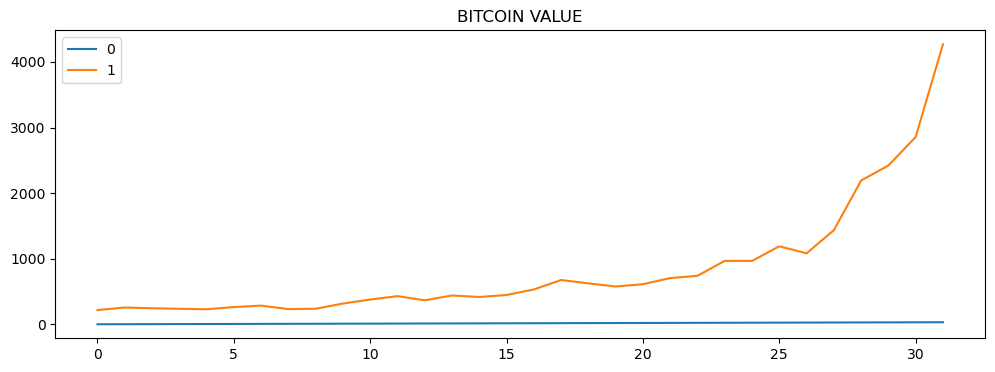

In [4]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('BITCOIN VALUE')
plt.show(block=False)

In [5]:
data.rename(columns={0:'day',1:'value'}, inplace=True)
data.head()

,day,value
0,0,217.4
1,1,255.7
2,2,244.3
3,3,236.1
4,4,228.7


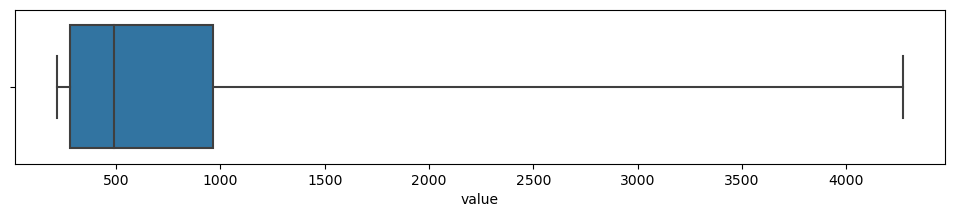

In [6]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['value'],whis=5)

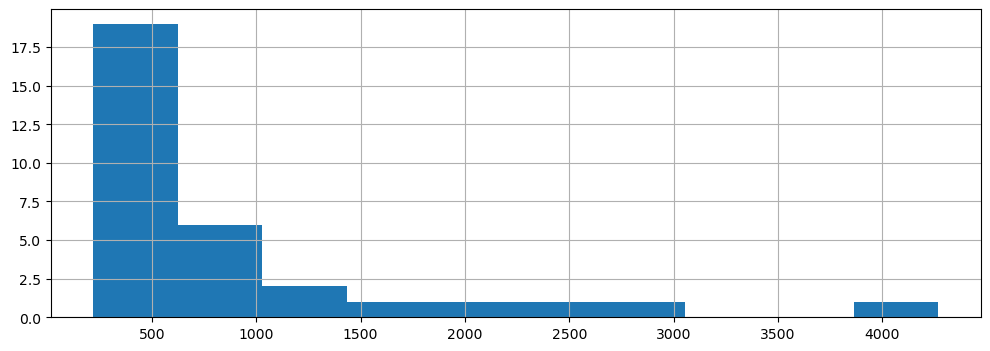

In [7]:
fig = data.value.hist(figsize = (12,4))

In [8]:
data.dtypes



day        int64
value    float64
dtype: object

In [9]:
#data.day.replace(0, np.nan, inplace=True)
data.head()

,day,value
0,0,217.4
1,1,255.7
2,2,244.3
3,3,236.1
4,4,228.7


In [10]:
data['month'] = pd.date_range('2020-04-3','2022-12-3', freq='m')

In [11]:
data.isnull().sum()

day      0
value    0
month    0
dtype: int64

In [12]:
data.head()

,day,value,month
0,0,217.4,2020-04-30
1,1,255.7,2020-05-31
2,2,244.3,2020-06-30
3,3,236.1,2020-07-31
4,4,228.7,2020-08-31


In [13]:
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')




In [14]:
data.head()

,day,value
month,,
2020-04-30,0,217.4
2020-05-31,1,255.7
2020-06-30,2,244.3
2020-07-31,3,236.1
2020-08-31,4,228.7


In [15]:
train_len = 29
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

In [16]:
data.head()

,day,value
month,,
2020-04-30,0,217.4
2020-05-31,1,255.7
2020-06-30,2,244.3
2020-07-31,3,236.1
2020-08-31,4,228.7


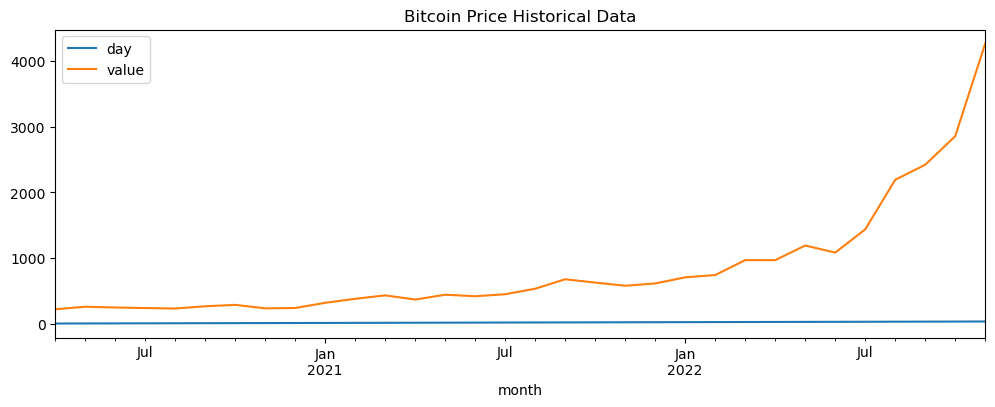

In [17]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Bitcoin Price Historical Data')
plt.show(block=False)

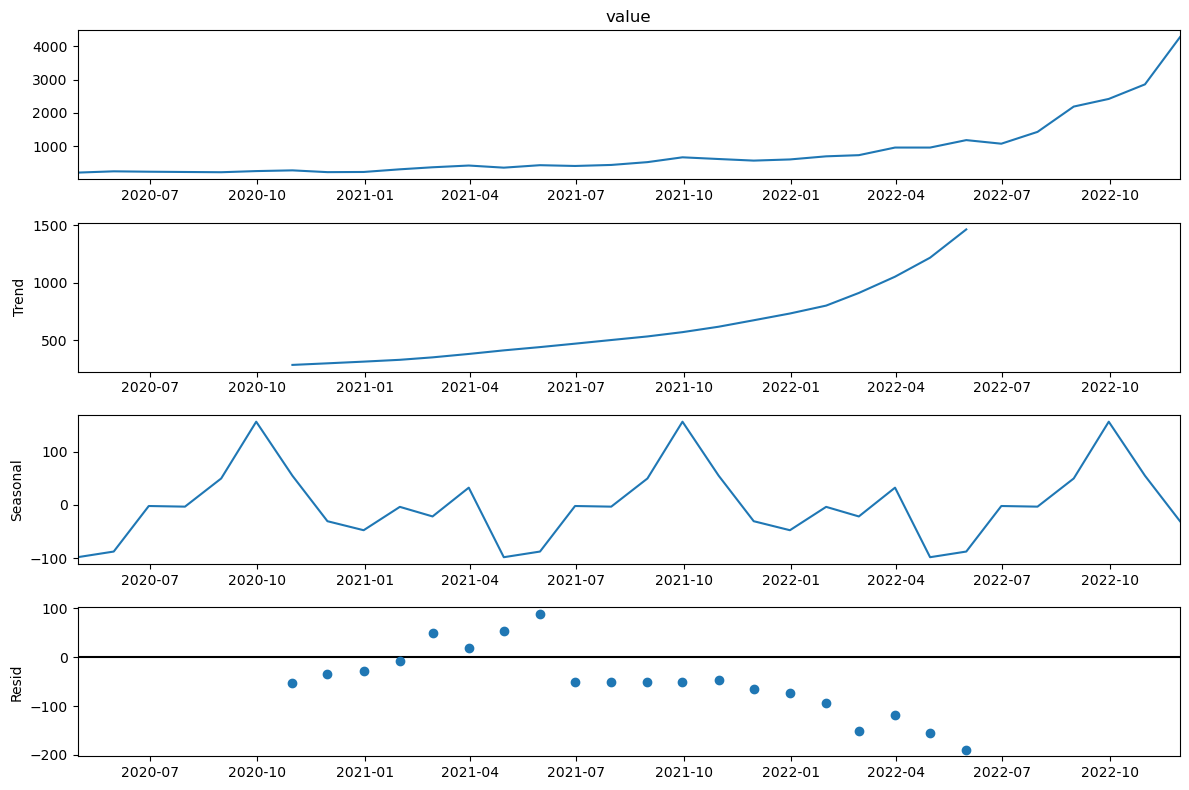

In [18]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.value, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

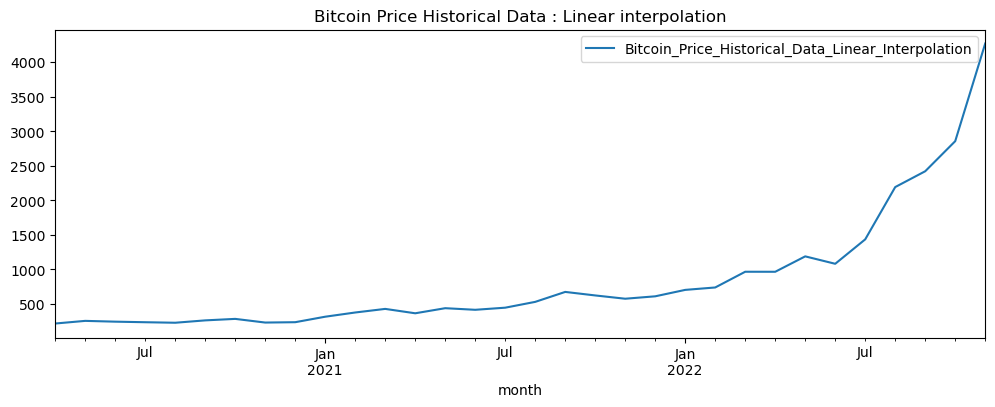

In [19]:
data = data.assign(Bitcoin_Price_Historical_Data_Linear_Interpolation=data.value.interpolate(method='linear'))
data[['Bitcoin_Price_Historical_Data_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Bitcoin Price Historical Data : Linear interpolation')
plt.show(block=False)

In [20]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['value'][train_len-1]

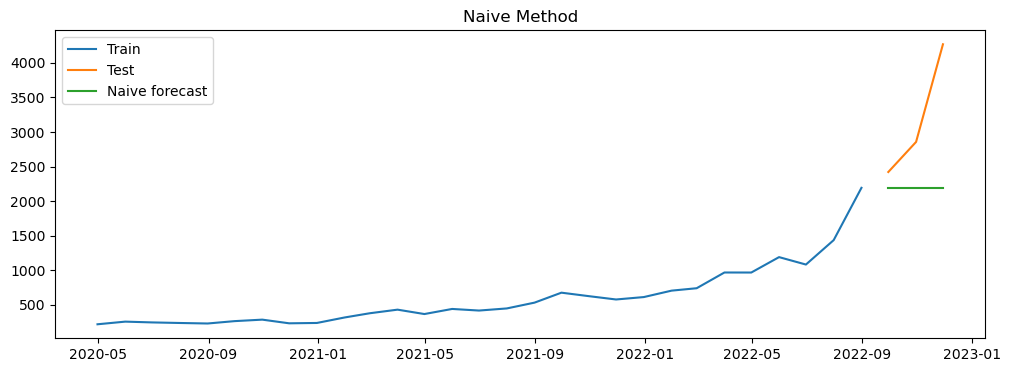

In [21]:
plt.figure(figsize=(12,4))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['value'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['value']-y_hat_naive['naive_forecast'])/test['value'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.9,27.12


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2020-04-30 to 2022-11-30
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   day                                                 32 non-null     int64  
 1   value                                               32 non-null     float64
 2   Bitcoin_Price_Historical_Data_Linear_Interpolation  32 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.0 KB


In [24]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['value'].mean()

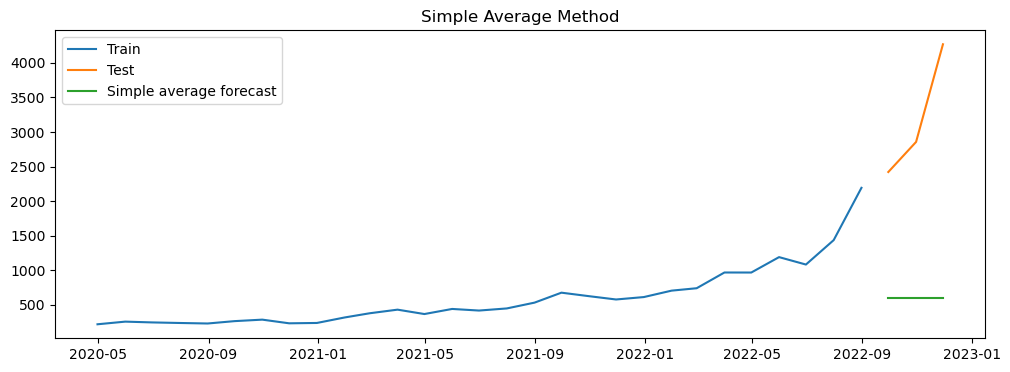

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [26]:
rmse = np.sqrt(mean_squared_error(test['value'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['value']-y_hat_avg['avg_forecast'])/test['value'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19


In [27]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['value'])
model_fit = model.fit(smoothing_level=0.2,optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


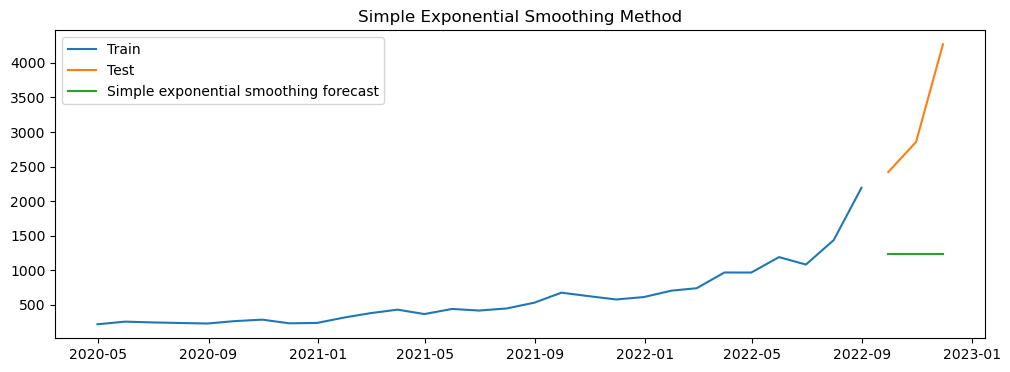

In [28]:
plt.figure(figsize=(12,4))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [29]:
rmse = np.sqrt(mean_squared_error(test['value'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['value']-y_hat_ses['ses_forecast'])/test['value'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple exponential smoothing forecast,2107.06,59.17


In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['value']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.195, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 222.41999999999993, 'initial_trend': 5.260000000000016, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


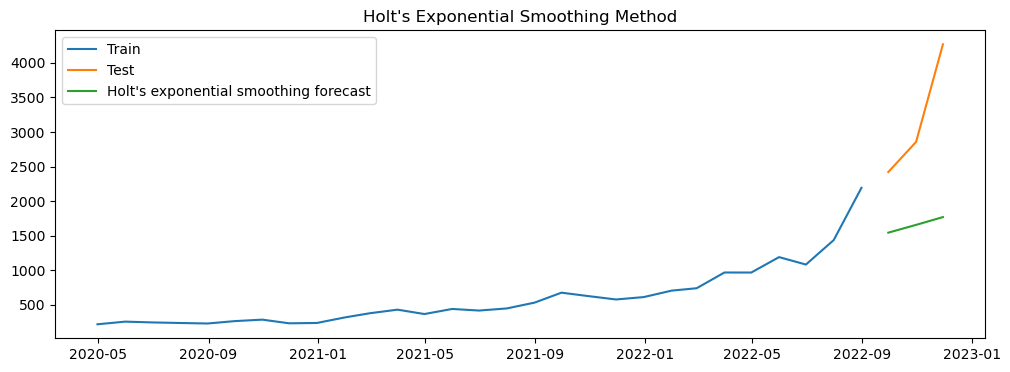

In [31]:
plt.figure(figsize=(12,4))
plt.plot( train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(test['value'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['value']-y_hat_holt['holt_forecast'])/test['value'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple exponential smoothing forecast,2107.06,59.17
0,Holt's exponential smoothing method,1679.63,45.62


In [33]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['value']) ,seasonal_periods=3 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(3)

{'smoothing_level': 0.994972143797732, 'smoothing_trend': 0.41334253777747204, 'smoothing_seasonal': 8.963128935425331e-05, 'damping_trend': nan, 'initial_level': 223.41248373262317, 'initial_trend': 12.541836031932924, 'initial_seasons': array([-14.50909963,  23.88343941,   6.77720824]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


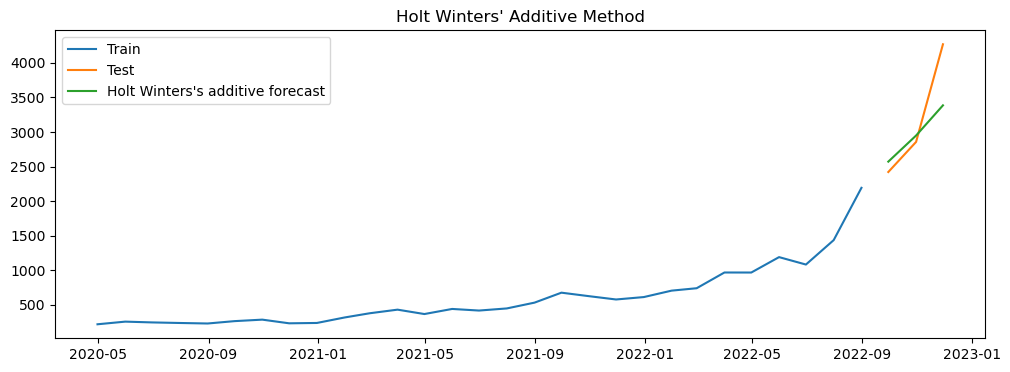

In [34]:
plt.figure(figsize=(12,4))
plt.plot( train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [35]:
rmse = np.sqrt(mean_squared_error(test['value'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['value']-y_hat_hwa['hw_forecast'])/test['value'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple exponential smoothing forecast,2107.06,59.17
0,Holt's exponential smoothing method,1679.63,45.62
0,Holt Winters' additive method,520.17,10.04
